# Tech Challenge Fase 2

# Aluno
Klauber Lage - RM358972

Link vídeo no Youtube: 

Link repositório no GitHub: https://github.com/klauberfreitas/fiap/tree/main/Fase%202/Tech%20Challenge

# O Problema
O desafio consiste em projetar, implementar e testar um sistema que 
utilize Algoritmos Genéticos para otimizar uma função ou resolver um problema 
complexo de otimização. Você pode escolher problemas como otimização de 
rotas, alocação de recursos e design de redes neurais.

# Tarefas
REQUISITOS DO PROJETO

- Definição do Problema: escolha um problema real que possa ser 
resolvido por meio de otimização genética. Descreva o problema, os 
objetivos e os critérios de sucesso.

- Testes e Resultados: realize testes para demonstrar a eficácia do 
algoritmo. Compare os resultados obtidos com métodos de solução 
convencionais.

- Documentação: forneça uma documentação completa do projeto, 
incluindo descrição do problema, detalhes da implementação do 
algoritmo, análises de resultados e conclusões.


### Referência:
[Documento PDF do Desafio](POSTECH-TechChallenge-IADT-Fase1.pdf)

---



# Relatório 

Usarei a mesma estrutura do primeiro Tech Challenge, seguindo a ordem de resolução dos problemas de acordo com o pedido. Escolhi design de redes neurais, por ser o que mais me interessou.

### O problema
Desenvolver um algoritmo genético para otimizar o design de redes neurais. Usarei o mesmo código ensinado na aula 4 de Computer Vision para isto, já que enquanto procurava por idéias, me deparei com a biblioteca DEAP para criar a estrutura do algoritmo genético.

O que é DEAP?

`DEAP é uma nova estrutura de computação evolutiva para prototipagem rápida e teste de ideias. Procura tornar os algoritmos explícitos e as estruturas de dados transparentes. Funciona em perfeita harmonia com mecanismos de paralelização como multiprocessamento e SCOOP.`

Trecho tirado do gitgub: https://github.com/DEAP/deap

### Objetivos
Otimizar a arquitetura de uma rede neural convolucional (CNNs) ajustando o número de filtros em cada camada convolucional, de forma a maximizar a precisão em tarefas específicas de classificação de imagens.

### Critérios de sucesso
Usarei o mesmo fluxo descrito na aula Princípios e conceitos fundamentais dos Algoritmos Genéticos como critérios de sucesso.

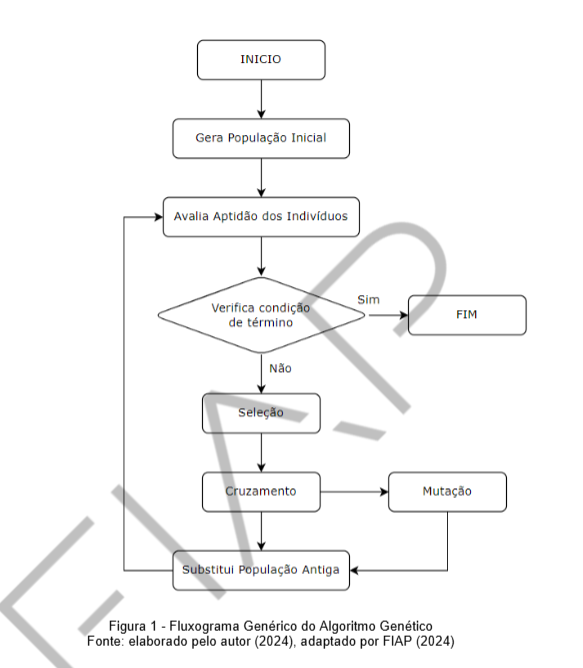


# 0 - Instalação e importação de dependências

In [ ]:
! pip install numpy matplotlib deap tensorflow

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms

# 1 - Definição dos Parâmetros/ Variáveis do Projeto
Variáveis/ parâmetros que controlam o comportamento da aplicação. 

Para fins de exemplo, deixarei com apenas 1 época e 3 gerações.

In [3]:
# Define o número de épocas para treinamento do modelo. Deixarei em somente 1 para que a execução seja rápida.
EPOCHS = 1
# Define o número de gerações
GENERATIONS = 3
# Define o número da população inicial 
POPULATION_SIZE = 10
# Define a probabilidade de cruzamento
CROSS_PROBABILITY = 0.5
# Define a probabilidade de mutação
MUTATION_PROBABILITY = 0.2
# Define o tamanho do torneio para seleção de indivíduos
TOURNAMENT_SIZE = 3

# 2 - Funções para Salvar e Carregar o Melhor Indivíduo

In [4]:
# Salva o melhor indivíduo e seu respectivo fitness (resultado) caso seja encontrado em cada execução,
# caso porque se na execução X não tiver um indivíduo melhor que o registrado em alguma execução anterior, não é registrado.
def save_best_individual(best_individual, best_fitness, filename="best_individual.json"):
    print("Indivíduo melhor foi encontrado e armazenado.")
    print("")
    data = {
        "best_individual": best_individual,
        "best_fitness": best_fitness
    }
    with open(filename, 'w') as f:
        json.dump(data, f)

# Carrega o melhor registrado salvo no arquivo best_individual.json
def load_best_individual(filename='best_individual.json'):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            data = json.load(f)
            return data['best_individual'], data['best_fitness']
    return None, None


# 3 - Funções de Avaliação e Treinamento do Modelo

In [5]:
# Define a função de avaliação do modelo.
# O código a seguir foi baseado no código da aula 4 de Computer Vision
def evaluate(individual, x_train, y_train, x_test, y_test, epochs):
    accuracy, _ = _model_training(individual, x_train, y_train, x_test, y_test, epochs)
    return accuracy,

def predict(individual, x_train, y_train, x_test, y_test, epochs):
    _, predictions  = _model_training(individual, x_train, y_train, x_test, y_test, epochs)
    return predictions

def _model_training(individual, x_train, y_train, x_test, y_test, epochs):
    # Construção do Modelo CNN
    model = models.Sequential([
        layers.Conv2D(individual[0], (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(individual[1], (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(individual[2], (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compilação do Modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinamento do Modelo
    model.fit(x_train, y_train, epochs=epochs, batch_size=128, verbose=0)
    
    # Previsão
    predictions = model.predict(x_test, verbose=0)
        
    # Avaliação do Modelo
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # Retorna a acurácia e as previsões
    return accuracy, predictions

# 4 - Carregamento e Pré-processamento dos Dados

In [6]:
# Carrega os dados de treino e teste do MNIST (números manuscritos), redimensiona e normaliza os dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
# Converte os rótulos de treino e teste (variáveis categóricas) para formato one-hot encoding 
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define a estrutura do indivíduo e a função de avaliação de fitness
# Cria a classe FitnessMax para maximizar a função de fitness e a classe Individual para representar os indivíduos da população
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Cria uma toolbox para registrar funções como gerar inteiros aleatórios, criar indivíduos, iniciar a população, realizar o cruzamento, mutação e seleção
toolbox = base.Toolbox()
# Registra a função para gerar inteiros aleatórios entre 16 e 64
toolbox.register("atribute_int", random.randint, 16, 64)
# Registra a função para criar indivíduos com 3 atributos [x, x, x]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.atribute_int, n=3)
# Registra a função para criar uma população de indivíduos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registra a função de cruzamento de dois pontos
toolbox.register("mate", tools.cxTwoPoint)
# Registra a função de mutação
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=MUTATION_PROBABILITY)
# Registra a função de seleção por torneio
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
# Registra a função de avaliação
toolbox.register("evaluate", evaluate, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, epochs=EPOCHS)

# Referência de operadores: https://deap.readthedocs.io/en/master/api/tools.html

# 5 - Configura e executa o Algoritmo Genético

In [ ]:
# Cria uma população inicial de 10 indivíduos
population = toolbox.population(n=POPULATION_SIZE)

# Lista para armazenar as melhores precisões de cada geração
best_fitnesses = []

# Lista para armazenar os resultados das gerações e apresentar ao final da execução
results = []

# Carregar o melhor indivíduo salvo, se existir
best_ind, best_fitness = load_best_individual()

# Se existir um melhor indivíduo salvo
if best_ind is not None:
    # Cria um indivíduo à partir do melhor indivíduo salvo
    best_individual = creator.Individual(best_ind)
    # Define o fitness de acordo com melhor indivíduo salvo
    best_individual.fitness.values = (best_fitness,)
    # Adiciona o melhor indivíduo salvo à população
    population.append(best_individual)
    # Adiciona o fitness do melhor indivíduo salvo à lista de melhores fitness para ser comparado logo a mais no código
    best_fitnesses.append(best_fitness)
    best_loaded = best_fitness
else:
    # Se não existir, inicia com dados zerados
    best_individual = None
    best_fitness = 0
    best_loaded = None

for gen in range(GENERATIONS):
    # Gera os filhos (nova geração) aplicando cruzamento e mutação e os avalia usando os operadores previamente configurados no '4 - Carregamento e Pré-processamento dos Dados'
    offspring = algorithms.varAnd(population, toolbox, CROSS_PROBABILITY, MUTATION_PROBABILITY)
    fits = toolbox.map(toolbox.evaluate, offspring)

    # Atribui o fitness ao indivíduo
    for fitness, individual in zip(fits, offspring):
        individual.fitness.values = fitness

    # Seleciona a nova população e seleciona o melhor indivóduo da população
    population = toolbox.select(offspring, k=len(population))
    best_ind = tools.selBest(population, 1)[0]
    # Adiciona a precisão do melhor indivíduo à lista de melhores fitnesses
    best_fitnesses.append(best_ind.fitness.values[0])

    # Imprime a melhor fitness da geração
    best_precision = f"Geração {gen}: Precisão = {best_ind.fitness.values[0]}"
    # Desabilite o print a seguir
    print(best_precision)
    results.append(best_precision)

    # Salva o melhor indivíduo se a precisão do melhor indivíduo for maior que a melhor precisão do indivíduo anterior
    if best_ind.fitness.values[0] > best_fitness:
        # Atualiza a melhor precisão
        best_fitness = best_ind.fitness.values[0]
        # Salva o melhor indivíduo
        save_best_individual(best_ind, best_fitness)

# Encontra o melhor indivíduo ao final do processo
# best_ind = tools.selBest(population, 1)[0]
# best_fitness = best_ind.fitness.values[0]

# # Verificar se o melhor indivíduo final é melhor que o salvo anteriormente, caso for, salva o novo
# if best_fitness > best_fitnesses[-1]:
#     save_best_individual(best_ind, best_fitness)

# 6 - Geração do Gráfico de Evolução da Precisão
Impre o resultado das gerações e gera o gráfico com a evolução da precisão ao longo das gerações, porém, não necessáriamente a evolução será positiva.

In [ ]:
# Cria um gráfico com a evolução da precisão ao longo das gerações
plt.plot(best_fitnesses, marker='o') 
plt.title('Evolução da Precisão ao longo das Gerações')
plt.xlabel('Geração') 
plt.ylabel('Precisão') 
plt.grid(True)  
plt.show()  

# Imprime a melhor precisão da geração
if best_loaded is not None:
    print(f"Carregado: Precisão = {best_loaded}")
else:
    print(f"Primeira execução, não há melhor indivíduo registrado")
for result in results:
    print(result)

# 6 - Resultado/ Gráfico de Previsões
Gera o gráfico com o resultado de previsão dos números reais e dos números previstos. Os números ficaram com a cor vermelha caso o valor previsto seja diferente do valor real.

In [ ]:
# Recebe as previsões a serem usados no gráfico abaixo
predictions = predict(individual, x_train, y_train, x_test, y_test, EPOCHS)

# Cria uma figura para plotar os resultados
plt.figure(figsize=(10, 10))  
for i in range(30):  
    plt.subplot(5, 6, i + 1) 
    # Remove os ticks 
    plt.xticks([]) 
    plt.yticks([]) 
    # Remove a grade
    plt.grid(False)  
    # Aplica configurações visuais
    plt.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)  
    predicted_label = np.argmax(predictions[i])  
    true_label = np.argmax(y_test[i])  
    color = 'blue' if predicted_label == true_label else 'red'  
    plt.xlabel(f'Previsto: {predicted_label}\nReal: {true_label}', color=color)  
plt.show()

Por fim, como podemos perceber na imagem a seguir, alguns valores podem ter sua previsão errada. Entretanto, ao registrarmos um melhor indivíduo que já consiga prever corretamente, todas as execuções posteriores passam a sempre retornar o conjunto atual corretamente, a não ser que alteremos os parâmetros configurados.

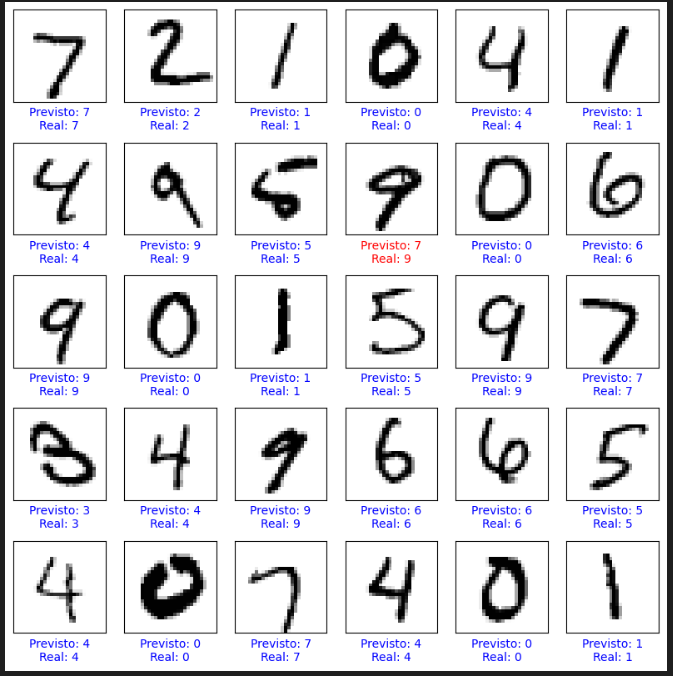

Abraços.